# 

# P5 - Convolutioneel neuraal netwerk

###### Door Peter Kemner, 1806201.

In dit notebook ga ik een convoltioneel neuraal netwerk maken om kleuren plaatjes te classificeren van de CIFAR-10 dataset. Deze notebook is het eerste deel van de opdracht waarbij het netwerk is gemaakt zonder aanvullende technieken.

# Opzet notebook

Het notebook heeft de volgende opzet:
- Data formatting,
- Modelling,
- Overplotting,
- Training en resultaten,
- Conclusie.

# Data formatting

Ik begin met de data voorbereiden voor het model, dit houdt in:
- data inladen,
- data splitsen,
- data vervormen,
- data veranderen.

In [24]:
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, Flatten, Activation, Dense
from tensorflow.keras.optimizers import SGD, Adam, schedules
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Data inladen/splitsen

Hier wordt de data ingeladen, de data wordt ook gelijk gesplits in 2 sets. De eerste gaat gebruikt worden om het model op te trainen en laatste is om het model te testen. De shape van de data wordt ook geprint, hieraan kan je zien wat de dementies zijn voor de input van het model en dat de y_train/test nog moet worden aangepast want dat moeten 10 categorieën worden.

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print("x_train shape", x_train.shape)
print("y_train shape", y_train.shape)
print("x_test shape", x_test.shape)
print("y_test shape", y_test.shape)

x_train shape (50000, 32, 32, 3)
y_train shape (50000, 1)
x_test shape (10000, 32, 32, 3)
y_test shape (10000, 1)


### Data vervormen

In [23]:
X_train = x_train.astype('float32')         
X_test = x_test.astype('float32')

X_train /= 255                              
X_test /= 255

Hier worden de correcte antwoorden van de train en test set naar 10 veranderd want dat zijn alle mogelijk mogelijkheden. Het maakt de resultaten een array met de lengte 10 en dat is veel handiger om de resultaten van het netwerk te vergelijken.

In [18]:
nb_classes = 10

Y_train = utils.to_categorical(y_train, nb_classes)
Y_test = utils.to_categorical(y_test, nb_classes)

print(f"Y_train: {Y_train.shape}, Y_test: {Y_test.shape}")

Y_train: (50000, 10), Y_test: (10000, 10)


### Data veranderen

Hier heb ik een deel van de test set gepakt en een beetje gedraait/verplaatst. Dit ga ik gebruiken om te testen of het netwerk de globale patronen heeft geleert en niet alleen van de plaatjes.
bron: https://keras.io/api/preprocessing/image/ en Les_10_Convolutionele_neurale_netwerken_MNIST.ipynb

In [21]:
new_data = ImageDataGenerator(rotation_range=40, shear_range=20)
new_data.fit(X_test)

X_test_augmented, Y_test_augmented = next(new_data.flow(X_test, Y_test, batch_size=X_test.shape[0], shuffle=False))

# Modeling

### De architectuur
**1. Conv layer.**

De eerste laag heeft 3 32x32 fotos waar elk van de foto hoort bij de een van de rgb kleuren. Er gaan over de alle fotos in de laag 32 3x3 filters met de relu functie.

**2. Conv layer.**

De tweede laag krijgt de 32 activatie maps van de vorige laag en gaat daar weer met 32 3x3 filters overheen met de relu functie.

**3. Conv layer.**

De derde laag krijgt de 32 activatie maps van de vorige laag en gaat daar weer met 32 3x3 filters overheen met de relu functie.

**4. Max pooling.**

De vierde laag is een pooling layer van 2x2, dit wordt gebruikt om de data te verkleinen en op de belangerijk waardes te focusen.

**5. Conv layer.**

De derde laag krijgt de verkleinde data van de pooling laag en gaat daar met 64 3x3 filters overheen met de relu functie.

**6. Conv layer.**

De zesde laag krijgt de 64 activatie maps van de vorige laag en gaat daar weer met 64 3x3 filters overheen met de relu functie.

**7. Max pooling.**

De zevende laag is een pooling layer van 2x2, deze verkleint de data weer.

**8. Conv layer.**

De derde laag krijgt de verkleinde data van de pooling laag en gaat daar met 128 3x3 filters overheen met de relu functie.

**9. Flatten.**


In [11]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(32, 32, 3)))
model.add(Activation('relu') )

model.add(Conv2D(filters=32, kernel_size=(3, 3)))
model.add(Activation('relu') )

model.add(Conv2D(filters=32, kernel_size=(3, 3)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3)))
model.add(Activation('relu'))

model.add(Conv2D(filters=64, kernel_size=(3, 3)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3)))
model.add(Activation('relu'))

model.add(Flatten())

model.add(Dense(500))
model.add(Activation('relu'))

model.add(Dense(300))
model.add(Activation('relu'))

model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 activation (Activation)     (None, 30, 30, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 28, 28, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        9248      
                                                                 
 activation_2 (Activation)   (None, 26, 26, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0

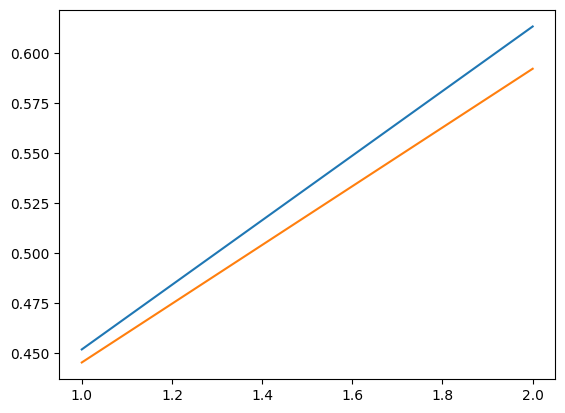

In [13]:
def plot_overfitting(max_epochs, model):
    initial_weights = model.get_weights()
    train_acc = []
    test_acc = []
    for epoch in range(1, max_epochs + 1):
        model.fit(X_train, Y_train, batch_size = 128, epochs=epoch, verbose=0, validation_split = 0.2, validation_steps=12000//128)
        _, accuracy1 = model.evaluate(X_train, Y_train, verbose=0)
        _, accuracy2 = model.evaluate(X_test, Y_test, verbose=0)
        train_acc.append(accuracy1)
        test_acc.append(accuracy2)
    # return [accuracy1, accuracy2]
    
    plt.plot(range(1, max_epochs + 1), train_acc, label='Training Accuracy')
    plt.plot(range(1, max_epochs + 1), test_acc, label='Testing Accuracy')
    plt.show()
    model.set_weights(initial_weights)

plot_overfitting(2, model)

# train_acc = []
# test_acc = []
# max_epochs = 2

# for x in range(1, max_epochs + 1):
#     train_acc.append(plot_overfitting(x)[0])
#     test_acc.append(plot_overfitting(x)[1])

# plt.plot(range(1, max_epochs + 1), train_acc, label='Training Accuracy')
# plt.plot(range(1, max_epochs + 1), test_acc, label='Testing Accuracy')
# plt.show()

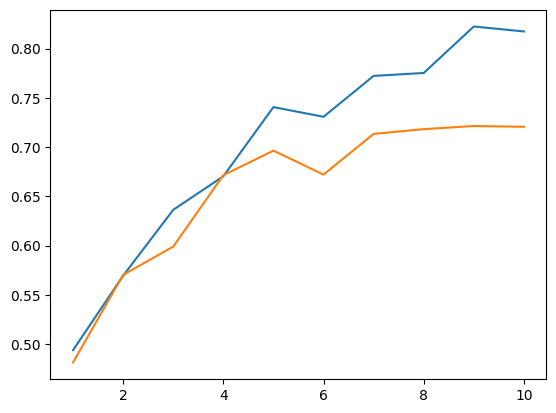

In [14]:
# model.fit(X_train, Y_train, batch_size = 128, epochs=4, verbose=1, validation_split = 0.2, validation_steps=12000//128)

Epoch 1/4
313/313 [==============================] - 24s 77ms/step - loss: 2.0760 - accuracy: 0.2095 - val_loss: 1.7389 - val_accuracy: 0.3511
Epoch 2/4
313/313 [==============================] - 21s 67ms/step - loss: 1.6230 - accuracy: 0.3988
Epoch 3/4
313/313 [==============================] - 21s 66ms/step - loss: 1.4386 - accuracy: 0.4739
Epoch 4/4
313/313 [==============================] - 23s 72ms/step - loss: 1.2840 - accuracy: 0.5362


In [15]:
loss, accuracy = model.evaluate(X_test, Y_test)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

313/313 [==============================] - 2s 8ms/step - loss: 1.2171 - accuracy: 0.5614
Test loss: 1.2171
Test accuracy: 0.5614


In [16]:
datagen.fit(X_test)
X_test_augmented, Y_test_augmented = next(datagen.flow(X_test, Y_test, batch_size=10_000))

In [17]:
loss, accuracy = model.evaluate(X_test_augmented, Y_test_augmented)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

313/313 [==============================] - 3s 8ms/step - loss: 1.2816 - accuracy: 0.5310
Test loss: 1.2816
Test accuracy: 0.5310
